# Atividade 03 - Aprendizado Supervisionado 1

Aluno: Pedro Henrique Cardoso Paulo<br>
Disciplina: HIML<br>
Professor: Helon

Nessa atividade seguiremos usando as bases de dados consideradas na atividade 2. Realizaremos novamente um fit usando o SoftMax e compararemos com os métodos SVC e KNN

## Passo 0 - Importando bibliotecas

In [22]:
# Pacotes padrao
import numpy as np
from os import getcwd
from os.path import join 
import matplotlib.pyplot as plt
import pickle
from datetime import datetime

# Normalizadores
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Reducao de dimensionalidade
from sklearn.decomposition import PCA

# Separação em treino e teste
from sklearn.model_selection import train_test_split

# Modelos
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# Metricas de erro
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

## Passo 1 - Importando os dados

In [23]:
fname = join(getcwd(),'data','data_postAR.pkl')
with open(fname, 'rb') as file:
    X1, y = pickle.load(file)

In [24]:
print(X1.shape, y.shape)

(850, 124) (850,)


## Passo 2 - Replicando pré-processamento

O pré-processamento será feito usando as mesmas regras de um caso anterior do exercício, assim, as etapas a serem seguidas serão:

* Divisão em treino e teste (50% de teste)
* Normalização dos dados
* Aplicação do PCA (99% de variância)

Como no exercício anterior todos os preditores apresentaram bons resultados, nesse exercício vamos buscar usar o perditor de melhor desempenho numérico

### 2.1 - Separando treino e teste

In [25]:
#Pequenas melhorias desde a última rodada
# 1 - Mudando a seed aleatória pra 37 (número que passou pela minha cabeça)
# 2 - Usando o parâmetro stratify pra melhorar a segregação das classes
# 3 - Estamos usando 50% só pra treino, pra deixar mais interessante o erro
size = 0.5
X1_tr, X1_te, y_tr, y_te = train_test_split(X1, y, test_size=size, random_state=37, stratify=y)

### 2.2 - Normalizando os dados

In [26]:
scaler = MinMaxScaler()
scaler.fit(X1_tr)
X1_tr = scaler.transform(X1_tr)
X1_te = scaler.transform(X1_te)

### 2.3 - Aplicando PCA

In [27]:
n_comp = 0.99
pca = PCA(n_components = n_comp)
pca.fit(X1_tr)
X1_tr_pca = pca.transform(X1_tr)
X1_te_pca = pca.transform(X1_te)

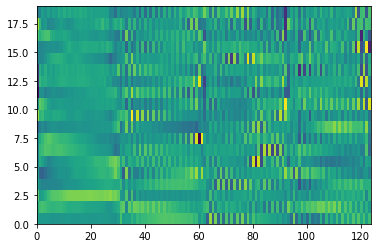

In [28]:
#Visualizando os PCs
plt.pcolor(pca.components_)

NOTA: Quis refazer esse teste pois creio ser mais certo não deixar, sob nenhuma hipótese, o conjunto de treino ser contaminado com o conjunto de teste. Isso inclui rodar o PCA e o normalizador apenas no treino e extender o resultado pro teste. UMa coisa que vale comentar e que pareceu bem legal é que os componentes calculados do PCA parecem com os anteriormente calculados usando o conjunto todo. (Para mais infos, ver nb da atividade 2)

## Passo 3 - Ajuste dos modelos

Pra facilitar, vamos criar uma função que gere as comparações que a gnt quer ver. Ela vai receber um dicionário com modelo, parâmetros a testar e vai printar uns resultados pra gente de forma automática.

In [29]:
def teste_esperto(dicio_modelo, plot=True):
    output = []
    for nome_modelo in dicio_modelo.keys():
        print('Testando modelo: {}'.format(nome_modelo))
        # Instanciando o modelo
        model_class = dicio_modelo[nome_modelo][0]
        model_inp = dicio_modelo[nome_modelo][1]
        t0 = datetime.now()
        model = model_class(**model_inp).fit(X1_tr_pca, y_tr)
        t1 = datetime.now()
        
        score_train = model.score(X1_tr_pca, y_tr)
        score_test = model.score(X1_te_pca, y_te)
        output.append([nome_modelo, score_train, score_test])

        print('    Train score: {}'.format(score_train))
        print('    Test score: {}'.format(score_test))
        print()
        print('    Adjustment took {}'.format((t1 - t0)))
        print()
    
        #Plotting confusion matrix
        if plot:
            cm = confusion_matrix(y_te, model.predict(X1_te_pca))
            cmgraph = ConfusionMatrixDisplay(cm)
            fig, ax = plt.subplots()
            ax.set_title(nome_modelo)
            cmgraph.plot(ax=ax)
            #plt.show()
            
    return np.array(output)
        

### 3.1 - SoftMax

Aqui vamos apenas repetir os procedimentos usados no modelo SoftMax, mas aqui vamos tentar mexer um pouco nos parâmetros tbm

Testando modelo: SoftMax1
    Train score: 0.9929411764705882
    Test score: 0.9882352941176471

    Adjustment took 0:00:00.090312



array([['SoftMax1', '0.9929411764705882', '0.9882352941176471']],
      dtype='<U32')

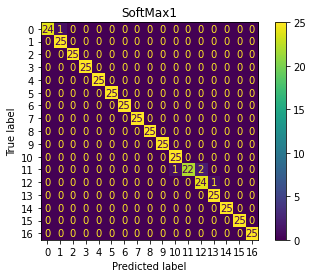

In [30]:
dicio_softmax = {'SoftMax1':[LogisticRegression, {'multi_class':'multinomial', 'random_state':37, 'max_iter':5000, 'solver':'saga'}]}
teste_esperto(dicio_softmax)

Vamos agora testar com alguns diferentes parâmetros de regularização

Testando modelo: SM1
    Train score: 0.9011764705882352
    Test score: 0.8847058823529412

    Adjustment took 0:00:00.012065

Testando modelo: SM2
    Train score: 0.9882352941176471
    Test score: 0.9741176470588235

    Adjustment took 0:00:00.014961

Testando modelo: SM3
    Train score: 0.9929411764705882
    Test score: 0.9882352941176471

    Adjustment took 0:00:00.101728

Testando modelo: SM4
    Train score: 1.0
    Test score: 0.9905882352941177

    Adjustment took 0:00:00.485399

Testando modelo: SM5
    Train score: 1.0
    Test score: 0.9952941176470588

    Adjustment took 0:00:00.499417

Testando modelo: SM6
    Train score: 1.0
    Test score: 0.9976470588235294

    Adjustment took 0:00:00.728820



<BarContainer object of 6 artists>

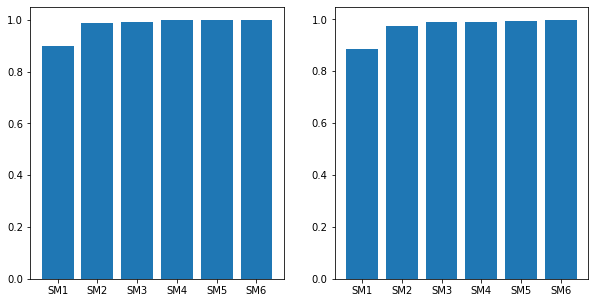

In [31]:
#Teste 1 - Regularização
dicio_softmax = {'SM1':[LogisticRegression, {'penalty': 'elasticnet', 'C': 0.01, 'l1_ratio':0, 'multi_class':'multinomial', 'random_state':37, 'max_iter':5000, 'solver':'saga'}],
                 'SM2':[LogisticRegression, {'penalty': 'elasticnet', 'C': 0.1, 'l1_ratio':0, 'multi_class':'multinomial', 'random_state':37, 'max_iter':5000, 'solver':'saga'}],
                 'SM3':[LogisticRegression, {'penalty': 'elasticnet', 'C': 1, 'l1_ratio':0, 'multi_class':'multinomial', 'random_state':37, 'max_iter':5000, 'solver':'saga'}],
                 'SM4':[LogisticRegression, {'penalty': 'elasticnet', 'C': 10, 'l1_ratio':0, 'multi_class':'multinomial', 'random_state':37, 'max_iter':5000, 'solver':'saga'}],
                 'SM5':[LogisticRegression, {'penalty': 'elasticnet', 'C': 100, 'l1_ratio':0, 'multi_class':'multinomial', 'random_state':37, 'max_iter':5000, 'solver':'saga'}],
                 'SM6':[LogisticRegression, {'penalty': 'elasticnet', 'C': 1000, 'l1_ratio':0, 'multi_class':'multinomial', 'random_state':37, 'max_iter':5000, 'solver':'saga'}],}
output = teste_esperto(dicio_softmax, plot=False)

# Plotando os erros
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
ax[0].bar(output[:,0], output[:,1].astype(float), alpha=1)
ax[1].bar(output[:,0], output[:,2].astype(float), alpha=1)

Testando modelo: SM1
    Train score: 0.058823529411764705
    Test score: 0.058823529411764705

    Adjustment took 0:00:00.011023

Testando modelo: SM2
    Train score: 0.8541176470588235
    Test score: 0.8588235294117647

    Adjustment took 0:00:00.126723

Testando modelo: SM3
    Train score: 0.9952941176470588
    Test score: 0.9882352941176471

    Adjustment took 0:00:01.666957

Testando modelo: SM4
    Train score: 1.0
    Test score: 0.9905882352941177

    Adjustment took 0:00:02.080285

Testando modelo: SM5
    Train score: 1.0
    Test score: 0.9976470588235294

    Adjustment took 0:00:02.407707

Testando modelo: SM6
    Train score: 1.0
    Test score: 0.9976470588235294

    Adjustment took 0:00:01.863978



<BarContainer object of 6 artists>

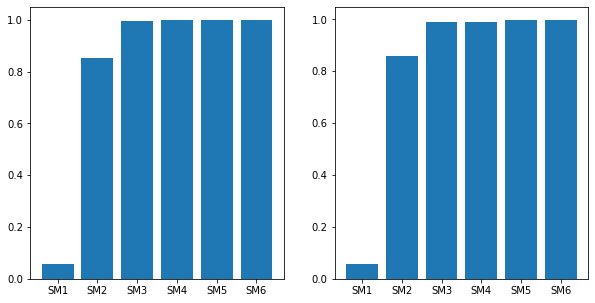

In [32]:
#Teste 2 - Métrica
dicio_softmax = {'SM1':[LogisticRegression, {'penalty': 'elasticnet', 'C': 0.01, 'l1_ratio':1, 'multi_class':'multinomial', 'random_state':37, 'max_iter':5000, 'solver':'saga'}],
                 'SM2':[LogisticRegression, {'penalty': 'elasticnet', 'C': 0.1, 'l1_ratio':1, 'multi_class':'multinomial', 'random_state':37, 'max_iter':5000, 'solver':'saga'}],
                 'SM3':[LogisticRegression, {'penalty': 'elasticnet', 'C': 1, 'l1_ratio':1, 'multi_class':'multinomial', 'random_state':37, 'max_iter':5000, 'solver':'saga'}],
                 'SM4':[LogisticRegression, {'penalty': 'elasticnet', 'C': 10, 'l1_ratio':1, 'multi_class':'multinomial', 'random_state':37, 'max_iter':5000, 'solver':'saga'}],
                 'SM5':[LogisticRegression, {'penalty': 'elasticnet', 'C': 100, 'l1_ratio':1, 'multi_class':'multinomial', 'random_state':37, 'max_iter':5000, 'solver':'saga'}],
                 'SM6':[LogisticRegression, {'penalty': 'elasticnet', 'C': 1000, 'l1_ratio':1, 'multi_class':'multinomial', 'random_state':37, 'max_iter':5000, 'solver':'saga'}],}
output = teste_esperto(dicio_softmax, plot=False)

# Plotando os erros
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
ax[0].bar(output[:,0], output[:,1].astype(float), alpha=1)
ax[1].bar(output[:,0], output[:,2].astype(float), alpha=1)

Parece pelos resultados que a regularização piora os resultados do score. Vamos testar o extremo sem regularização

Testando modelo: SoftMax1
    Train score: 1.0
    Test score: 0.9976470588235294

    Adjustment took 0:00:01.017767



array([['SoftMax1', '1.0', '0.9976470588235294']], dtype='<U32')

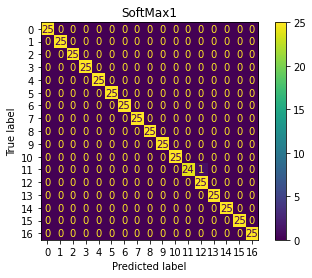

In [33]:
dicio_softmax = {'SoftMax1':[LogisticRegression, {'penalty': 'none','multi_class':'multinomial', 'random_state':37, 'max_iter':5000, 'solver':'saga'}]}
teste_esperto(dicio_softmax)

Conclusões gerais:

* Pro nosso conjunto, o problema tem bons resultados sem regularização (nosso conjunto parece cobrir bem o espaço das soluções, vira quase uma interpolação?
* Sem regularização o desempenho piora, demandando mais iterações
* Se for importante manter a regularização, melhor usarmos normas mais próximas da L2, pq mesmo com regularização considerável essa norma teve um desempenho melhor em score (88% de acurácia x 0.05% de acurácia)

### 3.2 - SVM

Testando modelo: SVM1
    Train score: 1.0
    Test score: 0.9929411764705882

    Adjustment took 0:00:00.007722



array([['SVM1', '1.0', '0.9929411764705882']], dtype='<U32')

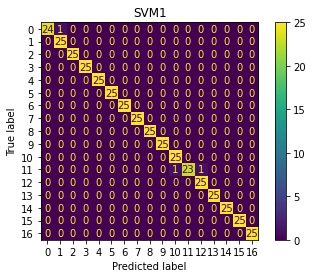

In [34]:
dicio_softmax = {'SVM1':[SVC, {'kernel':'rbf', 'random_state':37, 'max_iter':-1}]}
teste_esperto(dicio_softmax)

Testando modelo: SVM1
    Train score: 1.0
    Test score: 0.9976470588235294

    Adjustment took 0:00:00.006998

Testando modelo: SVM2
    Train score: 1.0
    Test score: 0.9858823529411764

    Adjustment took 0:00:00.004986

Testando modelo: SVM3
    Train score: 0.9764705882352941
    Test score: 0.9741176470588235

    Adjustment took 0:00:00.005549

Testando modelo: SVM4
    Train score: 0.9482352941176471
    Test score: 0.9458823529411765

    Adjustment took 0:00:00.005982

Testando modelo: SVM5
    Train score: 1.0
    Test score: 0.9929411764705882

    Adjustment took 0:00:00.007978

Testando modelo: SVM6
    Train score: 0.96
    Test score: 0.9552941176470588

    Adjustment took 0:00:00.006064



<BarContainer object of 6 artists>

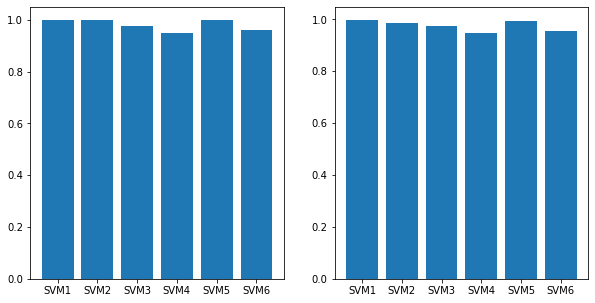

In [35]:
# Teste 1 - Testando o kernel
dicio_softmax = {'SVM1':[SVC, {'kernel':'linear', 'random_state':37, 'max_iter':-1}],
                 'SVM2':[SVC, {'kernel':'poly', 'degree': 2, 'random_state':37, 'max_iter':-1}],
                 'SVM3':[SVC, {'kernel':'poly', 'degree': 3,  'random_state':37, 'max_iter':-1}],
                 'SVM4':[SVC, {'kernel':'poly', 'degree': 4,  'random_state':37, 'max_iter':-1}],
                 'SVM5':[SVC, {'kernel':'rbf', 'random_state':37, 'max_iter':-1}],
                 'SVM6':[SVC, {'kernel':'sigmoid', 'random_state':37, 'max_iter':-1}],
                }
output = teste_esperto(dicio_softmax, plot=False)

# Plotando os erros
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
ax[0].bar(output[:,0], output[:,1].astype(float), alpha=1)
ax[1].bar(output[:,0], output[:,2].astype(float), alpha=1)

Com parâmetros default, rbf e linear forma os melhores. Esse resultado faz sentido, tendo em mente que o rbf é um que se ajusta bem pra uma gama grande de funções e linear teve excelente desempenho no SoftMax. Vamos manter esses dois e testar alguns C's.

Testando modelo: SVM1
    Train score: 0.9623529411764706
    Test score: 0.9317647058823529

    Adjustment took 0:00:00.009973

Testando modelo: SVM2
    Train score: 0.9952941176470588
    Test score: 0.9858823529411764

    Adjustment took 0:00:00.003986

Testando modelo: SVM3
    Train score: 1.0
    Test score: 0.9976470588235294

    Adjustment took 0:00:00.003989

Testando modelo: SVM4
    Train score: 1.0
    Test score: 0.9976470588235294

    Adjustment took 0:00:00.003989

Testando modelo: SVM5
    Train score: 1.0
    Test score: 0.9976470588235294

    Adjustment took 0:00:00.004987

Testando modelo: SVM6
    Train score: 0.9835294117647059
    Test score: 0.9647058823529412

    Adjustment took 0:00:00.016955

Testando modelo: SVM7
    Train score: 0.9835294117647059
    Test score: 0.9647058823529412

    Adjustment took 0:00:00.013963

Testando modelo: SVM8
    Train score: 1.0
    Test score: 0.9929411764705882

    Adjustment took 0:00:00.006978

Testando modelo: SVM

<BarContainer object of 10 artists>

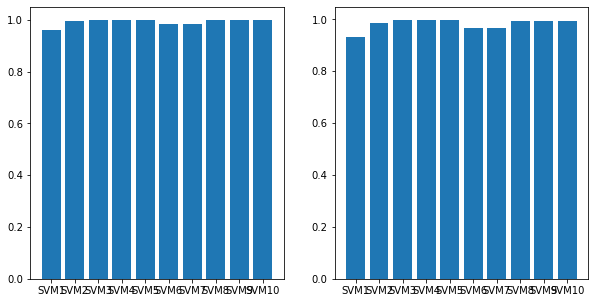

In [36]:
# Teste 2 - Testando o C
dicio_softmax = {'SVM1':[SVC, {'kernel':'linear', 'C':0.01, 'random_state':37, 'max_iter':-1}],
                 'SVM2':[SVC, {'kernel':'linear', 'C':0.1, 'random_state':37, 'max_iter':-1}],
                 'SVM3':[SVC, {'kernel':'linear', 'C':1, 'random_state':37, 'max_iter':-1}],
                 'SVM4':[SVC, {'kernel':'linear', 'C':10, 'random_state':37, 'max_iter':-1}],
                 'SVM5':[SVC, {'kernel':'linear', 'C':100, 'random_state':37, 'max_iter':-1}],
                 'SVM6':[SVC, {'kernel':'rbf', 'C':0.01, 'random_state':37, 'max_iter':-1}],
                 'SVM7':[SVC, {'kernel':'rbf', 'C':0.1, 'random_state':37, 'max_iter':-1}],
                 'SVM8':[SVC, {'kernel':'rbf', 'C':1, 'random_state':37, 'max_iter':-1}],
                 'SVM9':[SVC, {'kernel':'rbf', 'C':10, 'random_state':37, 'max_iter':-1}],
                 'SVM10':[SVC, {'kernel':'rbf', 'C':100, 'random_state':37, 'max_iter':-1}],
                }
output = teste_esperto(dicio_softmax, plot=False)

# Plotando os erros
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
ax[0].bar(output[:,0], output[:,1].astype(float), alpha=1)
ax[1].bar(output[:,0], output[:,2].astype(float), alpha=1)

Novamente, a regularização parece piorar a resposta do estudo, mas é interessante notar que com o SVM e kernel linear temos o mesmo resultado do SoftMax, mas com muito menos esforço computacional. O rbf não foi a melhor opção nem de longe nesse caso.

Testando modelo: SVM1
    Train score: 1.0
    Test score: 0.9976470588235294

    Adjustment took 0:00:00.003986



array([['SVM1', '1.0', '0.9976470588235294']], dtype='<U32')

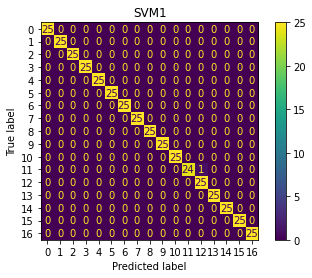

In [37]:
dicio_softmax = {'SVM1':[SVC, {'kernel':'linear', 'C':1, 'random_state':37, 'max_iter':-1}]}
teste_esperto(dicio_softmax)

### 3.3 - KNN

Testando modelo: KNN1
    Train score: 0.9905882352941177
    Test score: 0.9905882352941177

    Adjustment took 0:00:00.001029



array([['KNN1', '0.9905882352941177', '0.9905882352941177']], dtype='<U32')

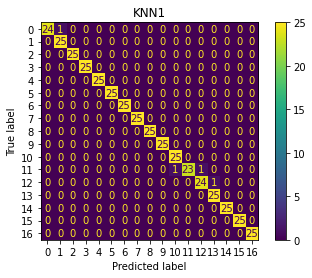

In [38]:
dicio_softmax = {'KNN1':[KNeighborsClassifier, {'n_neighbors':5,'weights':'uniform'}]}
teste_esperto(dicio_softmax)

Testando modelo: KNN1
    Train score: 1.0
    Test score: 0.9929411764705882

    Adjustment took 0:00:00.001981

Testando modelo: KNN2
    Train score: 1.0
    Test score: 0.9952941176470588

    Adjustment took 0:00:00.000997

Testando modelo: KNN3
    Train score: 0.9905882352941177
    Test score: 0.9905882352941177

    Adjustment took 0:00:00.001047

Testando modelo: KNN4
    Train score: 0.9858823529411764
    Test score: 0.9858823529411764

    Adjustment took 0:00:00

Testando modelo: KNN5
    Train score: 0.9858823529411764
    Test score: 0.9788235294117648

    Adjustment took 0:00:00.000998

Testando modelo: KNN6
    Train score: 0.9788235294117648
    Test score: 0.9576470588235294

    Adjustment took 0:00:00



<BarContainer object of 6 artists>

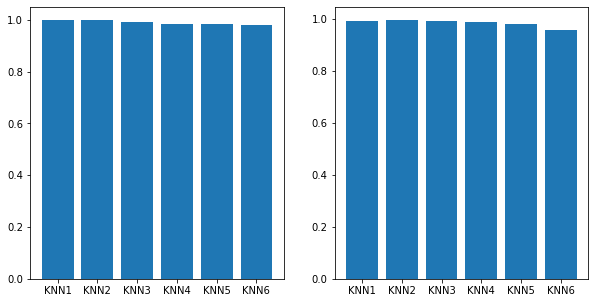

In [39]:
# Teste 1 - Testando o kn
dicio_softmax = {'KNN1':[KNeighborsClassifier, {'n_neighbors':1,'weights':'uniform'}],
                 'KNN2':[KNeighborsClassifier, {'n_neighbors':3,'weights':'uniform'}],
                 'KNN3':[KNeighborsClassifier, {'n_neighbors':5,'weights':'uniform'}],
                 'KNN4':[KNeighborsClassifier, {'n_neighbors':7,'weights':'uniform'}],
                 'KNN5':[KNeighborsClassifier, {'n_neighbors':10,'weights':'uniform'}],
                 'KNN6':[KNeighborsClassifier, {'n_neighbors':20,'weights':'uniform'}],
                }
output = teste_esperto(dicio_softmax, plot=False)

# Plotando os erros
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
ax[0].bar(output[:,0], output[:,1].astype(float), alpha=1)
ax[1].bar(output[:,0], output[:,2].astype(float), alpha=1)

Parece que 3 vizinhos é o limite pra termos um ótimo com os pesos uniformes (o KNN normal). Vamos testar em torno desse valor a opção de ponderarmos pela distância.

Testando modelo: KNN1
    Train score: 1.0
    Test score: 0.9929411764705882

    Adjustment took 0:00:00.001000

Testando modelo: KNN2
    Train score: 1.0
    Test score: 0.9952941176470588

    Adjustment took 0:00:00.001995

Testando modelo: KNN3
    Train score: 0.9905882352941177
    Test score: 0.9905882352941177

    Adjustment took 0:00:00.001996

Testando modelo: KNN4
    Train score: 1.0
    Test score: 0.9929411764705882

    Adjustment took 0:00:00.000974

Testando modelo: KNN5
    Train score: 1.0
    Test score: 0.9952941176470588

    Adjustment took 0:00:00.000991

Testando modelo: KNN6
    Train score: 1.0
    Test score: 0.9929411764705882

    Adjustment took 0:00:00.000997

Testando modelo: KNN7
    Train score: 1.0
    Test score: 0.9835294117647059

    Adjustment took 0:00:00.000999



<BarContainer object of 7 artists>

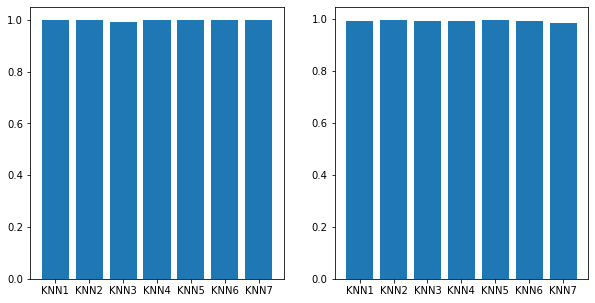

In [40]:
# Teste 2 - Testando o weight
dicio_softmax = {'KNN1':[KNeighborsClassifier, {'n_neighbors':1,'weights':'uniform'}],
                 'KNN2':[KNeighborsClassifier, {'n_neighbors':3,'weights':'uniform'}],
                 'KNN3':[KNeighborsClassifier, {'n_neighbors':5,'weights':'uniform'}],
                 'KNN4':[KNeighborsClassifier, {'n_neighbors':1,'weights':'distance'}],
                 'KNN5':[KNeighborsClassifier, {'n_neighbors':3,'weights':'distance'}],
                 'KNN6':[KNeighborsClassifier, {'n_neighbors':5,'weights':'distance'}],
                 'KNN7':[KNeighborsClassifier, {'n_neighbors':10,'weights':'distance'}],
                }
output = teste_esperto(dicio_softmax, plot=False)

# Plotando os erros
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
ax[0].bar(output[:,0], output[:,1].astype(float), alpha=1)
ax[1].bar(output[:,0], output[:,2].astype(float), alpha=1)

Testando modelo: KNN1
    Train score: 1.0
    Test score: 0.9952941176470588

    Adjustment took 0:00:00.000997



array([['KNN1', '1.0', '0.9952941176470588']], dtype='<U32')

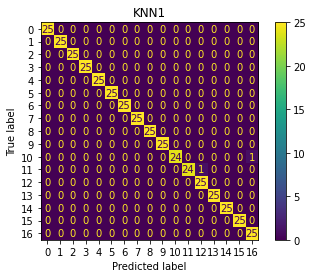

In [41]:
dicio_softmax = {'KNN1':[KNeighborsClassifier, {'n_neighbors':3,'weights':'uniform'}]}
teste_esperto(dicio_softmax)

Conclusões com o KNN:

* Pra 50% de conjunto de treino, o resultado não é tão bom em score
* Usar a distância pra ponderar é legal se quiser usar mais valores, mas não é tão impactante nesse caso, onde o ótimo são poucos vizinhos
* Pra esse conjunto, tá com um desempenho legal

## Passo 4 - Comparando os melhores modelos (segundo a avaliação atual)

Testando modelo: KNN1
    Train score: 1.0
    Test score: 0.9952941176470588

    Adjustment took 0:00:00.000973

Testando modelo: SVM1
    Train score: 1.0
    Test score: 0.9976470588235294

    Adjustment took 0:00:00.006931

Testando modelo: SoftMax1
    Train score: 1.0
    Test score: 0.9976470588235294

    Adjustment took 0:00:01.027909



<BarContainer object of 3 artists>

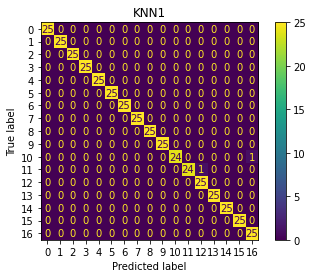

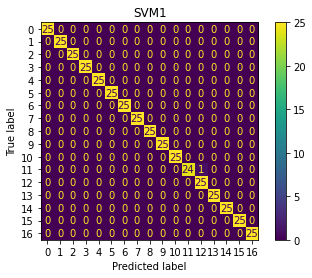

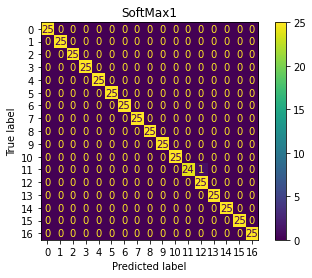

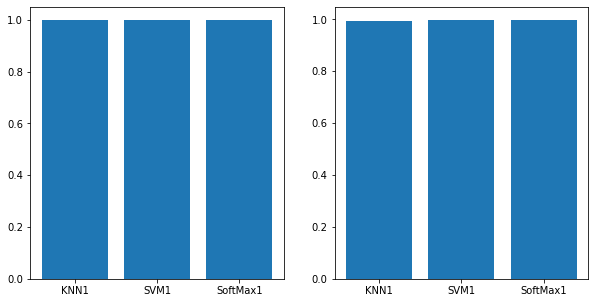

In [42]:
dicio_softmax = {'KNN1':[KNeighborsClassifier, {'n_neighbors':3,'weights':'uniform'}],
                 'SVM1':[SVC, {'kernel':'linear', 'C':1, 'random_state':37, 'max_iter':-1}],
                 'SoftMax1':[LogisticRegression, {'penalty': 'none','multi_class':'multinomial', 'random_state':37, 'max_iter':5000, 'solver':'saga'}]
                }
output = teste_esperto(dicio_softmax, plot=True)

# Plotando os erros
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
ax[0].bar(output[:,0], output[:,1].astype(float), alpha=1)
ax[1].bar(output[:,0], output[:,2].astype(float), alpha=1)

## Conclusões

* O problema parece responder bem a parametrizações lineares
* Pra 50% de teste, o KNN tem um desempenho bom
* Pro nosso caso, o SoftMax e o SVM tiverem o mesmo desempenho (inclusive com a mesma matriz de confusão), mas o SVM foi melhor em performence